# Make some noise!

By André van Schaik, \
International Centre for Neuromorphic Systems, \
Western Sydney University, \
January 2021

**This notebook shows how to generate noise with a user defined distribution AND a user defined autocorrelation.**

It is based on the method described in:\
J.M. Nichols, C.C. Olson, J.V. Michalowicz, F. Bucholtz,\
*A simple algorithm for generating spectrally colored, non-Gaussian signals,*\
Probabilistic Engineering Mechanics,\
Volume 25, Issue 3, 2010, Pages 315-322, ISSN 0266-8920,\
https://doi.org/10.1016/j.probengmech.2010.01.005.

My function takes a noise sequence sampled from the desired distribution (xi) and a vector describing the (2-sided) autocorrelation function (acf), and the sample frequency of the signal (fs), and returns the original noise sequence with its samples reordered to achieve the desired autocorrelation of the noise.

In [1]:
from makesomenoise import *

The function is imported from makesomenoise.py, as well as a plotting function to display the results. I'm displaying the function here. It uses the fact that the power spectral density is the Fourier transform of the autocorrelation function. So it takes the Fourier transform of the noise sequence, and modifies the transformed signal to have amplitudes determined by the ACF, but maintains the original phase. Next it does an inverse Fourier transform to create a target sequence. The final step is to take the original noise samples (that still have the desired distribution) and put them in the same rank order as the samples in the target sequence. These operations are repeated until convergence, i.e., until the order of the samples no longer changes between two iterations.


```python
def makesomenoise(xi, acf, fs):

    import numpy as np

    N = xi.shape[0]          # Get number of samples
    psd = np.fft.fft(acf, N) # Calculate PSD (Power Spectral Density) from ACF
    psd[0] = 0               # Zero out the DC component (remove mean)
    
    Af = np.sqrt(2 * np.pi * fs * N * psd) # Convert PSD to Fourier amplitudes
    mx = np.mean(xi)         # Calculate mean of samples 
    x  = xi - mx             # Make zero mean
    xs = np.sort(x)          # Store sorted signal xs with correct PDF
    k  = 1 
    idxr = np.zeros(N)       # Reference index array
    while(k != 0):
        Fx  = np.fft.fft(x)  # Compute FT of noise
        Px  = np.arctan2(np.imag(Fx), np.real(Fx))  # Get phases
        # Create a signal with correct PSD and original phases
        xg  = np.real(np.fft.ifft((np.exp(1.j*Px)) * np.abs(Af))) 
        idx = np.argsort(xg) # Get rank indices of signal with correct PSD
        x[idx] = xs          # Put original noise samples in desired rank order. 
        k = k+1              # Increment counter
        if (idx == idxr).all() :
            print(f'Number of iterations = {k}')
            k = 0            # If we converged, stop
        else:
            if k%500 == 0: print(f'Number of iterations = {k} ...')
            idxr = idx       # Re-set ordering for next iter
    x = x + mx               # Restore the original mean
    return(x)

```

In the next cell we define noise with a standard normal distribution, and a Gaussian ACF with precision 0.01.

In [3]:
#matplotlib widget
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from makesomenoise import *

fs      = 1           # Sample frequency
dt      = 1/fs        # Time step
dur     = 2**16*dt    # Duration of signal

# generate noise with Gaussian pdf
N       = int(dur*fs) # Number of noise samples
mu      = 0           # Mean of pdf
Pp      = 1           # Precision of pdf (P = 1/var = 1/scale**2)
scale   = 1/Pp**0.5   # Standard deviation of pdf
range1  = np.linspace(-5*scale, 5*scale, 200)     # plotting range of pdf
pdf     = norm.pdf(range1, loc=mu, scale=scale)   # pdf
xi      = np.random.normal(mu, scale, N)          # Input noise

# specify a Gaussian autocorrelation function
M       = 2**7        # Length of autocorrelation function
loc     = 0           # Maximum at zero lag
Pa      = 0.01        # Precision of autocorrelation
scale_a = 1/Pa**0.5   # Standard deviation of the acf

# generate a vector representing the autocorrelation function.
t       = (np.arange(M + 1) - M/2)*dt
acf     = norm.pdf(t, loc = loc*dt, scale = scale_a*dt)
acf     = acf/acf.max() # Normalise maximum to 1


Then we run the noise function. This might take a while, depending on the size of your noise sequence and the difficulty of matching the ACF.

In [4]:
xo = makesomenoise(xi, acf, fs)

Number of iterations = 500 ...
Number of iterations = 1000 ...
Number of iterations = 1156


Now, let's plot the results.

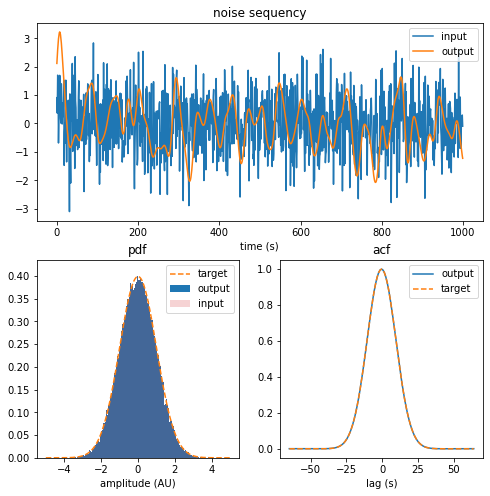

In [5]:
plot_noise(xi, xo, pdf, acf, fs, range1);

We see that the suffling of the noise sequence is creating a much smoothed noise signal (top), as imposed by our long autocorrelation function, which has correlations out to a lag of 25s (bottom right), but the histogram hasn't changed from the input histogram, since we only shuffled values, so that it still matches the desired pdf (bottom left).

Next, let's use a different sample rate:

Number of iterations = 500 ...
Number of iterations = 938


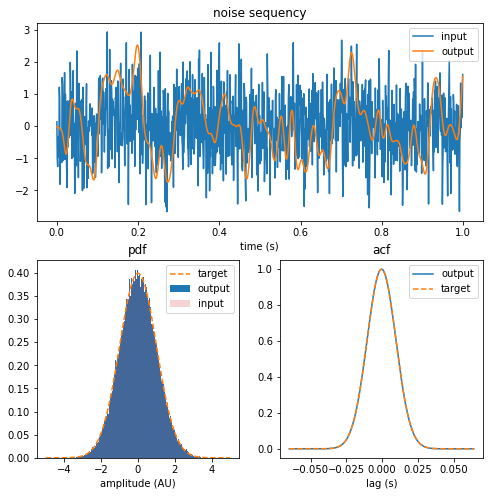

In [6]:
fs      = 1_000       # Sample frequency
dt      = 1/fs        # Time step
dur     = 2**16*dt    # Duration of signal

# generate noise with Gaussian pdf
N       = int(dur*fs) # Number of noise samples
mu      = 0           # Mean of pdf
Pp      = 1           # Precision of pdf (P = 1/var = 1/scale**2)
scale   = 1/Pp**0.5   # Standard deviation of pdf
range1  = np.linspace(-5*scale, 5*scale, 200)     # plotting range of pdf
pdf     = norm.pdf(range1, loc=mu, scale=scale)   # pdf
xi      = np.random.normal(mu, scale, N)          # Input noise

# specify a Gaussian autocorrelation function
M       = 2**7        # Length of autocorrelation function
loc     = 0           # Maximum at zero lag
Pa      = 0.01        # Precision of autocorrelation
scale_a = 1/Pa**0.5   # Standard deviation of the acf

# generate a vector representing the autocorrelation function.
t       = (np.arange(M + 1) - M/2)*dt
acf     = norm.pdf(t, loc = loc*dt, scale = scale_a*dt)
acf     = acf/acf.max() # Normalise maximum to 1

xo      = makesomenoise(xi, acf, fs)

plot_noise(xi, xo, pdf, acf, fs, range1);

As expected, this just changes the time axes. Now let's use a much shorter signal:

Number of iterations = 36


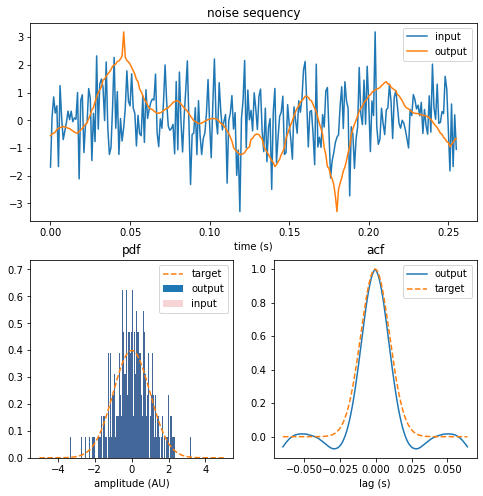

In [7]:
fs      = 1_000       # Sample frequency
dt      = 1/fs        # Time step
dur     = 2**8*dt     # Duration of signal

# generate noise with Gaussian pdf
N       = int(dur*fs) # Number of noise samples
mu      = 0           # Mean of pdf
Pp      = 1           # Precision of pdf (P = 1/var = 1/scale**2)
scale   = 1/Pp**0.5   # Standard deviation of pdf
range1  = np.linspace(-5*scale, 5*scale, 200)     # plotting range of pdf
pdf     = norm.pdf(range1, loc=mu, scale=scale)   # pdf
xi      = np.random.normal(mu, scale, N)          # Input noise

# specify a Gaussian autocorrelation function
M       = 2**7        # Length of autocorrelation function
loc     = 0           # Maximum at zero lag
Pa      = 0.01        # Precision of autocorrelation
scale_a = 1/Pa**0.5   # Standard deviation of the acf

# generate a vector representing the autocorrelation function.
t       = (np.arange(M + 1) - M/2)*dt
acf     = norm.pdf(t, loc = loc*dt, scale = scale_a*dt)
acf     = acf/acf.max() # Normalise maximum to 1

xo      = makesomenoise(xi, acf, fs)

plot_noise(xi, xo, pdf, acf, fs, range1);

With so few samples it becomes much harder to match the ACF.

OK, let's try a different ACF - a triangular one.

Number of iterations = 125


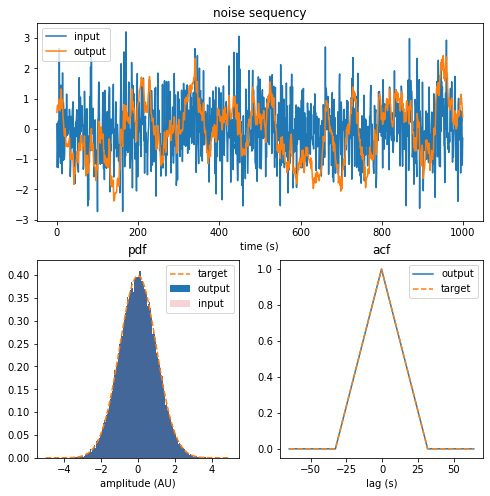

In [8]:
fs      = 1           # Sample frequency
dt      = 1/fs        # Time step
dur     = 2**16*dt    # Duration of signal

# generate noise with Gaussian pdf
N       = int(dur*fs) # Number of noise samples
mu      = 0           # Mean of pdf
Pp      = 1           # Precision of pdf (P = 1/var = 1/scale**2)
scale   = 1/Pp**0.5   # Standard deviation of pdf
range1  = np.linspace(-5*scale, 5*scale, 200) # plotting range of pdf
pdf     = norm.pdf(range1, loc=mu, scale=scale)   # pdf
xi      = np.random.normal(mu, scale, N)      # Input noise

# specify a triangular autocorrelation function
M       = 2**7        # Length of autocorrelation function
acf     = np.array([np.zeros(int(M/4)), np.arange(int(M/4))])
acf     = np.append(acf, np.flip(acf))
acf     = np.insert(acf, int(M/2), int(M/4))
acf     = acf/acf.max() # Don't forget to normalise to a maximum of 1

xo      = makesomenoise(xi, acf, fs)

plot_noise(xi, xo, pdf, acf, fs, range1);

No problem here. Now let's use a different noise - a mixture of two Gaussians

Number of iterations = 190


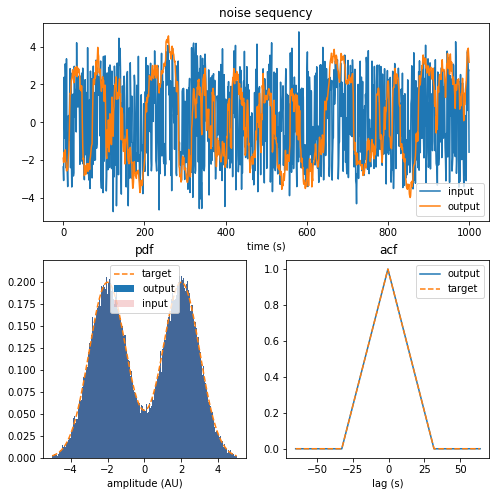

In [9]:
fs      = 1           # Sample frequency
dt      = 1/fs        # Time step
dur     = 2**16*dt    # Duration of signal

# generate noise with Gaussian pdf
N       = int(dur*fs) # Number of noise samples
mu      = 2           # Mean of pdf
Pp      = 1           # Precision of pdf (P = 1/var = 1/scale**2)
scale   = 1/Pp**0.5   # Standard deviation of pdf
range1  = np.linspace(-5, 5, 200) # plotting range of pdf
pdf     = norm.pdf(range1, loc=mu, scale=scale)/2    # pdf
pdf    += norm.pdf(range1, loc=-mu, scale=scale)/2
xi      = np.random.normal(mu, scale, int(N/2))      # Input noise
xi      = np.append(xi, np.random.normal(-mu, scale, int(N/2)))
np.random.shuffle(xi)

# specify a triangular autocorrelation function
M       = 2**7        # Length of autocorrelation function
acf     = np.array([np.zeros(int(M/4)), np.arange(int(M/4))])
acf     = np.append(acf, np.flip(acf))
acf     = np.insert(acf, int(M/2), int(M/4))
acf     = acf/acf.max() # Don't forget to normalise to a maximum of 1

xo      = makesomenoise(xi, acf, fs)

plot_noise(xi, xo, pdf, acf, fs, range1);

Still fine. Now let's make it difficult by restricting the amplitudes of the noise to a narrow range.

Number of iterations = 500 ...
Number of iterations = 546


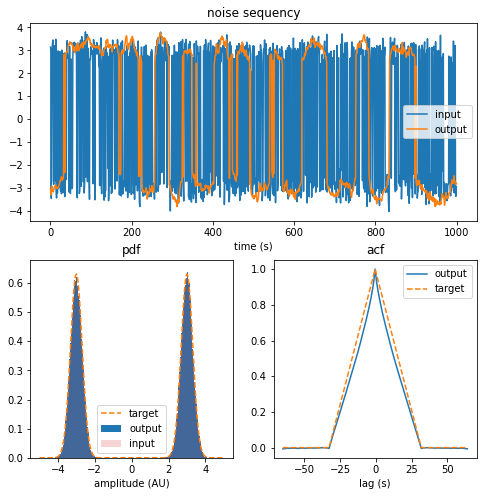

In [10]:
fs      = 1           # Sample frequency
dt      = 1/fs        # Time step
dur     = 2**16*dt    # Duration of signal

# generate noise with Gaussian pdf
N       = int(dur*fs) # Number of noise samples
mu      = 3           # Mean of pdf
Pp      = 10          # Precision of pdf (P = 1/var = 1/scale**2)
scale   = 1/Pp**0.5   # Standard deviation of pdf
range1  = np.linspace(-5, 5, 200) # plotting range of pdf
pdf     = norm.pdf(range1, loc=mu, scale=scale)/2    # pdf
pdf    += norm.pdf(range1, loc=-mu, scale=scale)/2
xi      = np.random.normal(mu, scale, int(N/2))      # Input noise
xi      = np.append(xi, np.random.normal(-mu, scale, int(N/2)))
np.random.shuffle(xi)

# specify a triangular autocorrelation function
M       = 2**7        # Length of autocorrelation function
acf     = np.array([np.zeros(int(M/4)), np.arange(int(M/4))])
acf     = np.append(acf, np.flip(acf))
acf     = np.insert(acf, int(M/2), int(M/4))
acf     = acf/acf.max() # Don't forget to normalise to a maximum of 1

xo      = makesomenoise(xi, acf, fs)

plot_noise(xi, xo, pdf, acf, fs, range1);

Still pretty good. Notice how the output signal is now almost binary.